In [3]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def linear(x, slope, intercept):
    return slope*x + intercept

def cost(func, params, xdata, ydata):
    squared_error = func(xdata, *params) - ydata
    return sum(squared_error)

This function calculates the parameters which result from retraining with an additional datapoint *new* that is weighted by some amount *epsilon*.

In [5]:
# Influence functions are defined as the first-order Taylor approximation of this around epsilon = 0
# Or maybe the derivative if it's more convenient to subtract off the value at 0, I think I've seen both definitions
def response_function(new, epsilon, func, xdata, ydata):
    if epsilon == 0:
        params, _ = curve_fit(func, xdata, ydata)
        return params
    else:
        newxdata = np.concatenate((np.array([new[0]]), xdata))
        newydata = np.concatenate((np.array([new[1]]), ydata))
        weights = np.array([epsilon] + [1 for _ in xdata])
        params, _ = curve_fit(func, newxdata, newydata, sigma=1.0/weights)
        return params

This looks at each data point in the training data, and computes how much changing its weight impacts the cost function. It then sorts the data points by how much increasing their weight decreases the cost function.

In [ ]:
def order_by_cost_influence(epsilon, func, xdata, ydata, cost):
    influences = []
    for i in range(len(xdata)):
        params0 = response_function((xdata[i],ydata[i]), 0, func, xdata, ydata)
        params1 = response_function((xdata[i],ydata[i]), epsilon, func, xdata, ydata)
        cost0 = cost(func, params0, xdata, ydata)
        cost1 = cost(func, params1, xdata, ydata)
        influences += [(cost1 - cost0)/epsilon]
    data = [((xdata[i], ydata[i]), influences[i]) for i in range(len(xdata))]
    return sorted(data, key = lambda x: x[1])

In [25]:
xdata = np.array([0, 1, 2, 3, 4, 3])
ydata = np.array([0, 1, 2, 3, 4, 5])

Influence functions being a good approximation of response functions assumes that we should see our results vary linearly with epsilon, for small epsilon. For linear models, this does seem to hold.

[((4, 4), -0.41666666666757735), ((3, 3), -0.37500000000081934), ((2, 2), -0.2631578947374189), ((1, 1), -0.11904761904788219), ((0, 0), 0.0), ((3, 5), 1.2500000000027272)]
[((4, 4), -0.06124636369525316), ((3, 3), -0.04604758267370501), ((2, 2), -0.030717225572602924), ((1, 1), -0.015339776296805496), ((0, 0), -3.703215512018687e-10), ((3, 5), 0.15349194075893413)]
[((4, 4), -0.006153552678900276), ((3, 3), -0.0046152781084440875), ((2, 2), -0.003076871003404591), ((1, 1), -0.00153841656296283), ((0, 0), 9.325873406851315e-12), ((3, 5), 0.015385785505772631)]
[((4, 4), -0.0006153843208345222), ((3, 3), -0.000452248342774908), ((2, 2), -0.0003076922538980398), ((1, 1), -0.00015384610607682703), ((0, 0), 4.440892098500626e-12), ((3, 5), 0.0015384611928848102)]


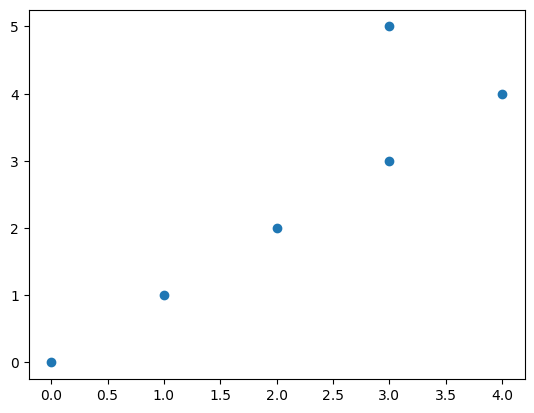

In [26]:
model = linear

print(order_by_cost_influence(1, model, xdata, ydata, cost))
print(order_by_cost_influence(0.1, model, xdata, ydata, cost))
print(order_by_cost_influence(0.01, model, xdata, ydata, cost))
print(order_by_cost_influence(0.001, model, xdata, ydata, cost))
plt.scatter(xdata,ydata)
plt.show()